In [1]:
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, count as spark_count, concat_ws, length, rand, row_number
from pyspark.sql.window import Window
import pandas as pd

from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

def measure_time(func, *args, **kwargs):
    start = time.perf_counter()
    result = func(*args, **kwargs)
    end = time.perf_counter()
    return result, end - start

measure_time

<function __main__.measure_time(func, *args, **kwargs)>

In [2]:
spark = SparkSession.builder \
    .appName("RAID_TRAIN_XLM-ROBERTA-RF") \
    .master("spark://spark-master:7077") \
    .getOrCreate()

spark

In [3]:
df = spark.read.json("hdfs://namenode:8020/user/raid/raw")
df

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

# Total Baris

In [4]:
print("Menghitung total jumlah baris...")
total_rows, time_0 = measure_time(lambda: df.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_0:.4f} detik")

Menghitung total jumlah baris...
✅ Total baris: 481,356 | Waktu: 5.7351 detik


# Filter

In [5]:
print("Memfilter data: length(generation) > 50...")
df_filtered, filter_time = measure_time(
    lambda: df.filter(length(col("generation")) > 50)
)

print(f"✅ Filter selesai dalam {filter_time:.2f} detik")

Memfilter data: length(generation) > 50...
✅ Filter selesai dalam 0.03 detik


In [6]:
df_filtered = df_filtered.repartition(128)
df_filtered

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string]

# Split

In [7]:
print("[1] Menghitung total jumlah baris...")
total_rows, time_0 = measure_time(lambda: df_filtered.count())
print(f"✅ Total baris: {total_rows:,} | Waktu: {time_0:.4f} detik")

[1] Menghitung total jumlah baris...
✅ Total baris: 481,196 | Waktu: 7.2251 detik


In [8]:
print("[2] Membuat kolom stratifikasi 'model_domain_attack' ...")
df_with_strata, strat_time = measure_time(
    lambda: df_filtered.withColumn(
        "model_domain_attack",
        concat_ws("_", col("model"), col("domain"), col("attack"))
    )
)
print(f"✅ Kolom stratifikasi dibuat dalam {strat_time:.4f} detik")

[2] Membuat kolom stratifikasi 'model_domain_attack' ...
✅ Kolom stratifikasi dibuat dalam 0.0326 detik


In [9]:
df_with_strata = df_with_strata.repartition(128)
df_with_strata

DataFrame[attack: string, domain: string, features: array<double>, generation: string, id: string, model: string, model_domain_attack: string]

In [10]:
print("[3] Menghitung jumlah baris per 'model_domain_attack' ...")
df_counts, count_time = measure_time(
    lambda: df_with_strata.groupBy("model_domain_attack").agg(spark_count("*").alias("total_per_group"))
)
print(f"✅ Selesai dalam {count_time:.4f} detik")

[3] Menghitung jumlah baris per 'model_domain_attack' ...
✅ Selesai dalam 0.0259 detik


In [11]:
print("[4] Gabungkan count ke setiap baris")
df_joined, join_time = measure_time(
    lambda: df_with_strata.join(df_counts, on="model_domain_attack", how="inner")
)
print(f"✅ Data berhasil digabung dengan count per grup dalam {join_time:.4f} detik")

[4] Gabungkan count ke setiap baris
✅ Data berhasil digabung dengan count per grup dalam 0.0355 detik


In [12]:
print("[5] Memberi nomor urut acak dalam setiap grup ...")
window_spec = Window.partitionBy("model_domain_attack").orderBy(rand())
df_numbered, number_time = measure_time(
    lambda: df_joined.withColumn("row_num", row_number().over(window_spec))
)
print(f"✅ Penomoran selesai dalam {number_time:.4f} detik")

[5] Memberi nomor urut acak dalam setiap grup ...
✅ Penomoran selesai dalam 0.0249 detik


In [13]:
# [6] Tentukan batas 70% → masuk train jika row_num <= 0.7 * total_per_group
print("[6] Menentukan split berdasarkan 70% per grup ...")
df_with_split, split_time = measure_time(
    lambda: df_numbered.withColumn(
        "is_train",
        col("row_num") <= (col("total_per_group") * 0.7)
    )
)
print(f"✅ Split logic selesai dalam {split_time:.4f} detik")

[6] Menentukan split berdasarkan 70% per grup ...
✅ Split logic selesai dalam 0.0214 detik


In [14]:
# [7] Pisahkan train dan test
train_df = df_with_split.filter(col("is_train")).select(
    col("generation").alias("text"),
    col("model"),
    col("features")
)
test_df = df_with_split.filter(~col("is_train")).select(
    col("generation").alias("text"),
    col("model"),
    col("features")
)

train_count, train_count_time = measure_time(lambda: train_df.count())
test_count, test_count_time = measure_time(lambda: test_df.count())

print(f"✅ Train: {train_count:,} ({train_count_time:.4f} detik) | Test: {test_count:,} ({test_count_time:.4f} detik)")

✅ Train: 336,761 (9.6820 detik) | Test: 144,435 (7.7177 detik)


In [15]:
from pyspark.ml.functions import array_to_vector

train_df = train_df.withColumn("features", array_to_vector(col("features")))
test_df = test_df.withColumn("features", array_to_vector(col("features")))

# Opsional: cek tipe kolom
train_df.printSchema()

root
 |-- text: string (nullable = true)
 |-- model: string (nullable = true)
 |-- features: vector (nullable = true)



# Train

In [16]:
from pyspark.ml.feature import StringIndexer, RegexTokenizer, StopWordsRemover, Word2Vec
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col

train_df, test_df

(DataFrame[text: string, model: string, features: vector],
 DataFrame[text: string, model: string, features: vector])

In [17]:
# === Pipeline: StringIndexer + LogisticRegression ===
print("Membangun pipeline...")

# StringIndexer untuk label 'model'
string_indexer = StringIndexer(
    inputCol="model",
    outputCol="label",
    handleInvalid="error"
)

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=100,
    maxDepth=10,
    seed=42
)

pipeline = Pipeline(stages=[string_indexer, rf])
pipeline

Membangun pipeline...


Pipeline_0912e116e572

In [18]:
# --- 3. Latih model ---
print("[14] Melatih model pada train_df...")
model, train_model_time = measure_time(
    lambda: pipeline.fit(train_df)
)
print(f"✅ Model berhasil dilatih dalam {train_model_time:.4f} detik")

[14] Melatih model pada train_df...
✅ Model berhasil dilatih dalam 278.1180 detik


In [19]:
# --- 4. Simpan model ke HDFS ---
model_path = "hdfs://namenode:8020/user/raid/model-xlmroberta-rf"
print(f"[15] Menyimpan model ke HDFS: {model_path}...")
_, save_time = measure_time(
    lambda: model.write().overwrite().save(model_path)
)
print(f"✅ Model disimpan dalam {save_time:.4f} detik")

[15] Menyimpan model ke HDFS: hdfs://namenode:8020/user/raid/model-xlmroberta-rf...
✅ Model disimpan dalam 6.8900 detik


In [20]:
# --- 5. Prediksi pada test set ---
print("[16] Melakukan prediksi pada test_df...")
predictions, predict_time = measure_time(
    lambda: model.transform(test_df)
)
print(f"✅ Prediksi selesai dalam {predict_time:.4f} detik")

# Tampilkan contoh
predictions.select("text", "model", "label", "prediction", "probability").show(5, truncate=50)

[16] Melakukan prediksi pada test_df...
✅ Prediksi selesai dalam 0.0678 detik
+--------------------------------------------------+-----+-----+----------+----------------------------------------+
|                                              text|model|label|prediction|                             probability|
+--------------------------------------------------+-----+-----+----------+----------------------------------------+
|The UK's adoption of digital TV and broadband h...|human|  1.0|       1.0|  [0.462245423587672,0.5377545764123279]|
|Chelsea boss Jose Mourinho has insisted that Si...|human|  1.0|       1.0|[0.13550155664843938,0.8644984433515607]|
|Tony Blair says his party's next manifesto will...|human|  1.0|       1.0|[0.17967528462454388,0.8203247153754561]|
|Nintendo is releasing an adapter for its DS han...|human|  1.0|       1.0| [0.3387122633077737,0.6612877366922263]|
|US comedian Bill Cosby will not face charges st...|human|  1.0|       1.0| [0.2531759819506994,0.74682

In [21]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# --- 6. Evaluasi berbagai metrik ---
print("[17] Evaluasi...")

# Accuracy
evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy, time_acc = measure_time(lambda: evaluator_acc.evaluate(predictions))

# Weighted Precision
evaluator_prec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision, time_prec = measure_time(lambda: evaluator_prec.evaluate(predictions))

# Weighted Recall
evaluator_rec = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall, time_rec = measure_time(lambda: evaluator_rec.evaluate(predictions))

# F1-score (weighted)
evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_score, time_f1 = measure_time(lambda: evaluator_f1.evaluate(predictions))

# Tampilkan hasil
print(f"✅ Accuracy    : {accuracy:.4f} | Waktu: {time_acc:.4f} detik")
print(f"✅ Precision   : {precision:.4f} | Waktu: {time_prec:.4f} detik")
print(f"✅ Recall      : {recall:.4f} | Waktu: {time_rec:.4f} detik")
print(f"✅ F1-score    : {f1_score:.4f} | Waktu: {time_f1:.4f} detik")

[17] Evaluasi...
✅ Accuracy    : 0.9402 | Waktu: 47.4410 detik
✅ Precision   : 0.9426 | Waktu: 149.0036 detik
✅ Recall      : 0.9391 | Waktu: 220.0701 detik
✅ F1-score    : 0.9385 | Waktu: 178.9535 detik


In [22]:
print("[18] Membuat confusion matrix dengan label string...")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ambil hasil prediksi ke Pandas
pred_pd, time_pred_pd = measure_time(lambda: predictions.select("model", "label", "prediction").toPandas())
print(f'✅ Selesai dalam {time_pred_pd:.4f} detik')
pred_pd

[18] Membuat confusion matrix dengan label string...
✅ Selesai dalam 350.7394 detik


,model,label,prediction
0,human,1.0,0.0
1,human,1.0,1.0
2,human,1.0,1.0
3,human,1.0,1.0
4,human,1.0,1.0
...,...,...,...
144430,human,1.0,0.0
144431,human,1.0,1.0
144432,human,1.0,1.0
144433,human,1.0,0.0


In [23]:
# Buat mapping label numerik ke string (gunakan data unik dari hasil prediksi)
label_map = (
    pred_pd[["label", "model"]]
    .drop_duplicates()
    .sort_values("label")
    .set_index("label")["model"]
    .to_dict()
)
label_map

{0.0: 'gpt4', 1.0: 'human'}

In [24]:
pred_pd["true_label"] = pred_pd["label"].map(label_map)
pred_pd["pred_label"] = pred_pd["prediction"].map(label_map)
pred_pd

,model,label,prediction,true_label,pred_label
0,human,1.0,0.0,human,gpt4
1,human,1.0,1.0,human,human
2,human,1.0,1.0,human,human
3,human,1.0,1.0,human,human
4,human,1.0,1.0,human,human
...,...,...,...,...,...
144430,human,1.0,0.0,human,gpt4
144431,human,1.0,1.0,human,human
144432,human,1.0,1.0,human,human
144433,human,1.0,0.0,human,gpt4


In [25]:
results_path = "hdfs://namenode:8020/user/raid/xlmroberta-rf_results.parquet"
print(f"Menyimpan hasil ke HDFS: {results_path}...")
_, save_time = measure_time(
    lambda: predictions.select("model", "label", "prediction") \
        .write.mode("overwrite") \
        .parquet(results_path)
)
print(f"✅ Hasil disimpan dalam {save_time:.4f} detik")

Menyimpan hasil ke HDFS: hdfs://namenode:8020/user/raid/xlmroberta-rf_results.parquet...
✅ Hasil disimpan dalam 657.2841 detik


In [26]:
# Ambil hanya label yang muncul di data
unique_labels = sorted(list(set(pred_pd["true_label"]) | set(pred_pd["pred_label"])))
len(unique_labels)

2

In [27]:
unique_labels

['gpt4', 'human']

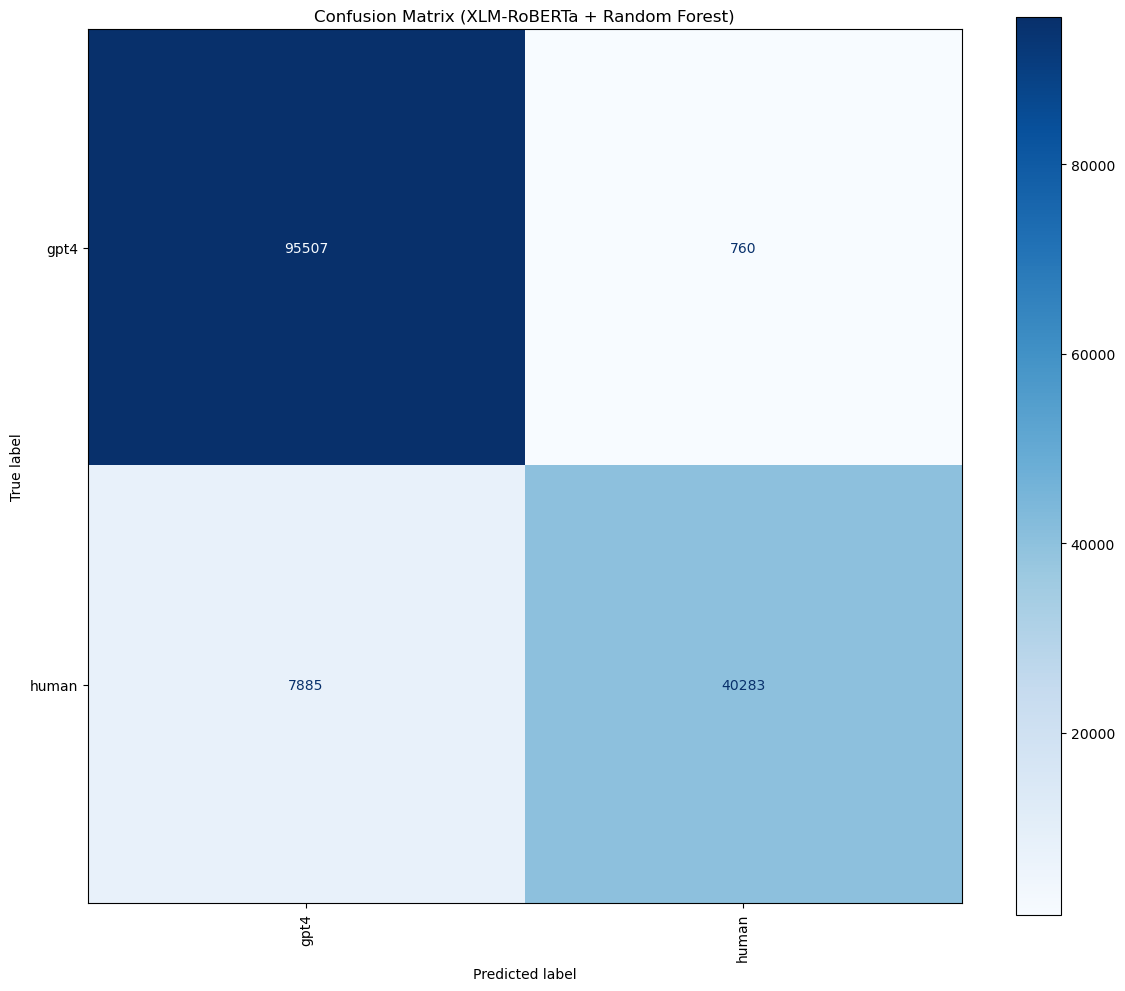

In [28]:
# Buat confusion matrix
cm = confusion_matrix(pred_pd["true_label"], pred_pd["pred_label"], labels=unique_labels)

# Visualisasi
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)
disp.plot(ax=ax, cmap="Blues", colorbar=True, xticks_rotation=90)

# Timpa teks lama dengan nilai dari cm secara langsung
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        disp.text_[i, j].set_text(f"{cm[i, j]}")  # atau tanpa koma: f"{cm[i, j]}"

plt.title("Confusion Matrix (XLM-RoBERTa + Random Forest)")
plt.tight_layout()
plt.show()

In [29]:
spark.stop()